# Comparision Between ARIMA and Chronous AI

## Importing Libraries for ARIMA And Chronous AI

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import torch  # PyTorch to convert values into torch tensors.
from chronos import ChronosPipeline


C:\Users\Barkha\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the data Set

In [2]:
df = pd.read_csv("Data/AirPassengers.csv")
df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
#convert months column from object to date time
df["Month"] = pd.to_datetime(df["Month"])
print(df)
# Method 1 (Direct Assignment):
df = df.rename(columns={"#Passengers": "Passengers"})



         Month  #Passengers
0   1949-01-01          112
1   1949-02-01          118
2   1949-03-01          132
3   1949-04-01          129
4   1949-05-01          121
..         ...          ...
139 1960-08-01          606
140 1960-09-01          508
141 1960-10-01          461
142 1960-11-01          390
143 1960-12-01          432

[144 rows x 2 columns]


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [6]:
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [7]:
df.set_index("Month", inplace=True)
df.head()


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


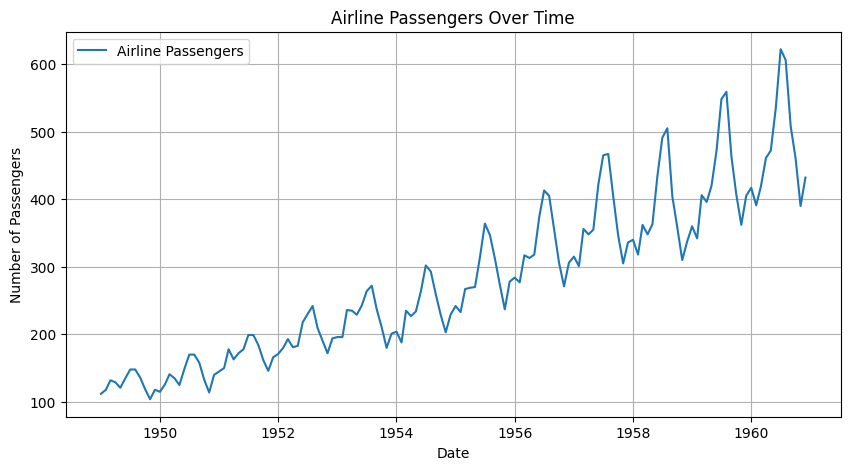

In [8]:

# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(df["Passengers"], label="Airline Passengers")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.title("Airline Passengers Over Time")
plt.legend()
plt.grid(True)
plt.show()


####  Check for Stationarity with Augmented Dickey-Fuller Test

In [9]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF Test
result = adfuller(df["Passengers"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] <= 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary, differencing is needed.")


ADF Statistic: 0.8153688792060463
p-value: 0.991880243437641
The data is not stationary, differencing is needed.


##### Doing differencing to remove trend and make the data stationary

In [10]:
df["Passengers_diff"] = df["Passengers"].diff().dropna()
df.head()



,Passengers,Passengers_diff
Month,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


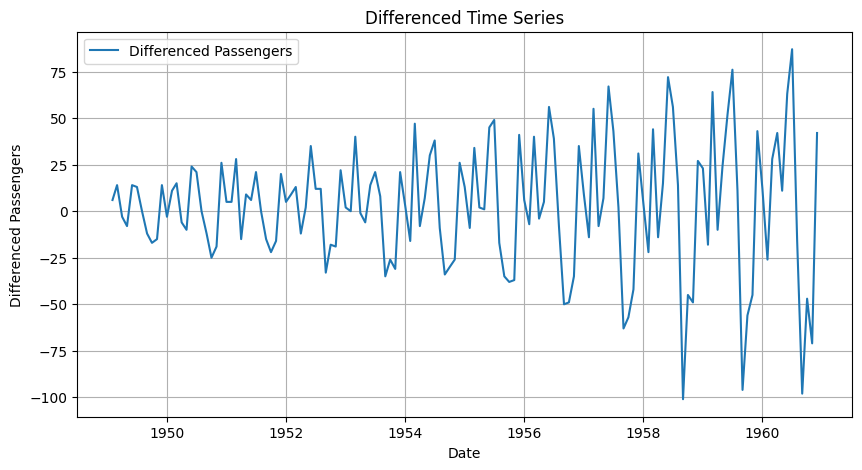

In [11]:
# plot of passengers_diff
plt.figure(figsize=(10, 5))
plt.plot(df["Passengers_diff"], label="Differenced Passengers")
plt.xlabel("Date")
plt.ylabel("Differenced Passengers")
plt.title("Differenced Time Series")
plt.legend()
plt.grid(True)
plt.show()

## ARIMA Model

C:\Users\Barkha\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Barkha\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Barkha\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -694.341
Date:                Sat, 15 Feb 2025   AIC                           1394.683
Time:                        13:40:49   BIC                           1403.571
Sample:                    01-01-1949   HQIC                          1398.294
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4742      0.123     -3.847      0.000      -0.716      -0.233
ma.L1          0.8635      0.078     11.051      0.000       0.710       1.017
sigma2       961.9270    107.433      8.954      0.0

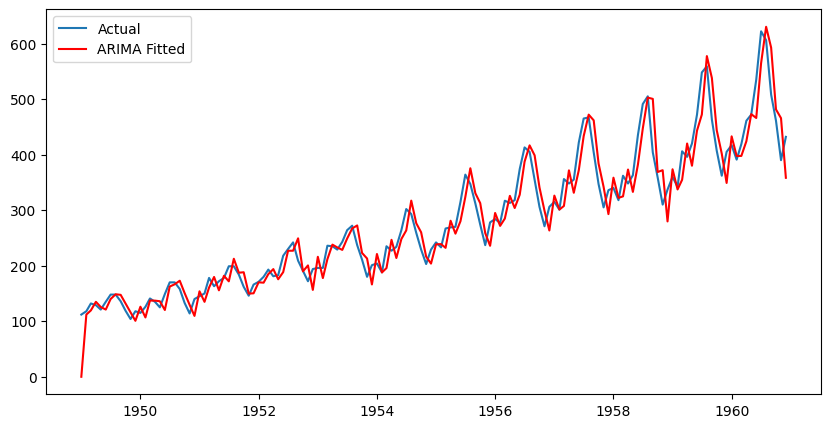

In [12]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (p=1, d=1, q=1 as an example)
model = ARIMA(df["Passengers"], order=(1, 1, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Plot forecast
plt.figure(figsize=(10, 5))
plt.plot(df["Passengers"], label="Actual")
plt.plot(model_fit.fittedvalues, label="ARIMA Fitted", color='red')
plt.legend()
plt.show()


### Forecast

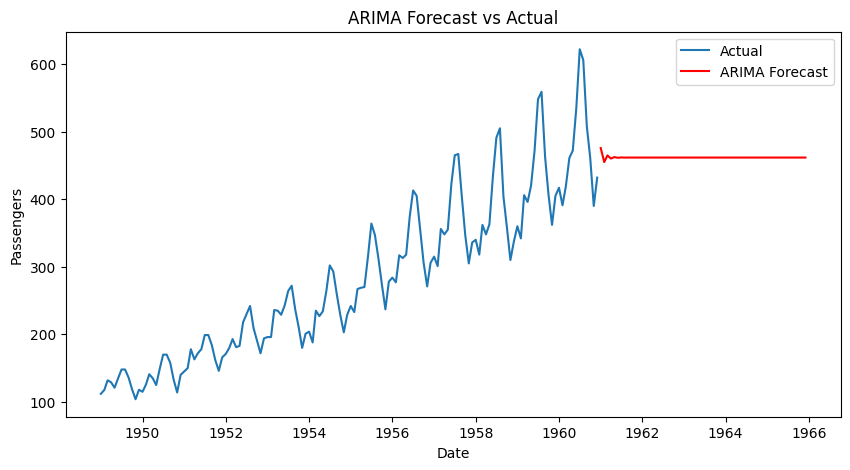

In [13]:
# ARIMA Forecast
forecast_steps = 60  # Next 5 year
arima_forecast = model_fit.forecast(steps=forecast_steps)

# Plot ARIMA Forecast
plt.figure(figsize=(10, 5))
plt.plot(df["Passengers"], label="Actual")
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps+1, freq='MS')[1:], 
         arima_forecast, label="ARIMA Forecast", color='red')
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()


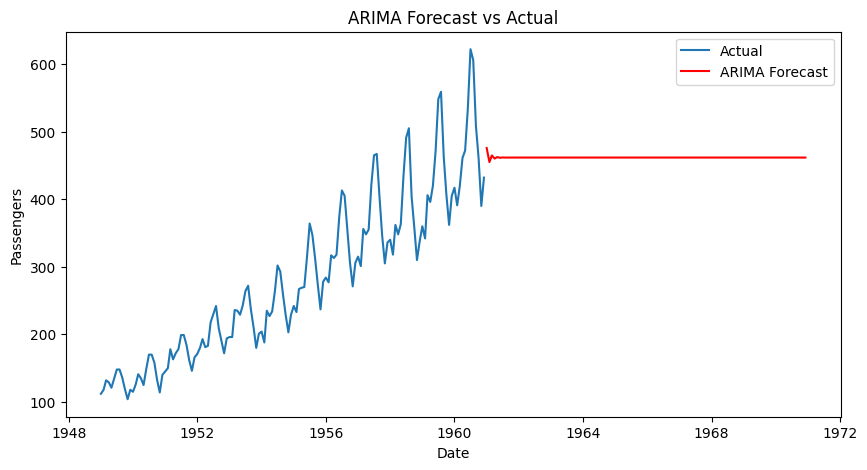

In [14]:
# ARIMA Forecast
forecast_steps = 120  # Next 10 year
arima_forecast = model_fit.forecast(steps=forecast_steps)

# Plot ARIMA Forecast
plt.figure(figsize=(10, 5))
plt.plot(df["Passengers"], label="Actual")
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps+1, freq='MS')[1:], 
         arima_forecast, label="ARIMA Forecast", color='red')
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()


# Chronous AI

In [15]:
# Load Chronos Model
pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-tiny",device_map="auto",torch_dtype=torch.bfloat16)


In [16]:
# Convert Passengers to Torch Tensor
to_predict = torch.tensor(df["Passengers"].values, dtype=torch.float32)

# Set Forecast Horizon
horizon_5_years = 60  # 5 years (monthly data)
horizon_10_years = 120  # 10 years (monthly data)


In [17]:
# 5-Year Forecast
forecast_5 = pipeline.predict(to_predict, horizon_5_years)
chronos_median_5 = np.median(forecast_5[0].numpy(), axis=0)

# 10-Year Forecast
forecast_10 = pipeline.predict(to_predict, horizon_10_years)
chronos_median_10 = np.median(forecast_10[0].numpy(), axis=0)


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


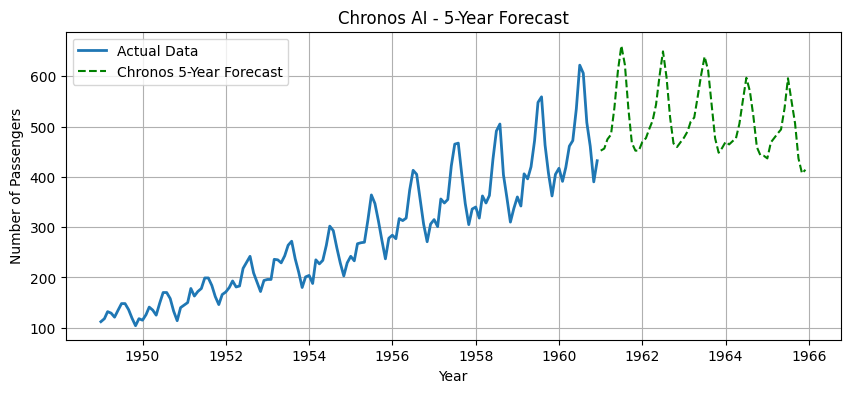

In [18]:
plt.figure(figsize=(10, 4))

# Original Data
plt.plot(df.index, df["Passengers"], label="Actual Data", linewidth=2)

# 5-Year Forecast
plt.plot(
    pd.date_range(df.index[-1], periods=horizon_5_years+1, freq='MS')[1:], 
    chronos_median_5, label="Chronos 5-Year Forecast", linestyle='--', color='green'
)

plt.title("Chronos AI - 5-Year Forecast")
plt.xlabel("Year")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid(True)
plt.show()


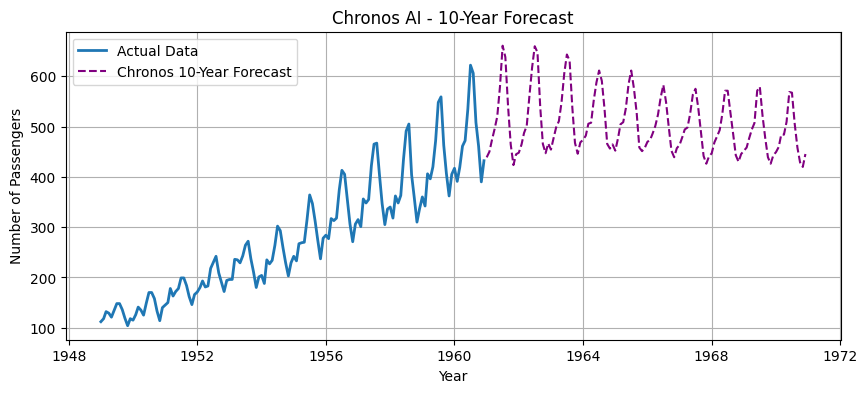

In [19]:
plt.figure(figsize=(10, 4))

# Original Data
plt.plot(df.index, df["Passengers"], label="Actual Data", linewidth=2)

# 10-Year Forecast
plt.plot(
    pd.date_range(df.index[-1], periods=horizon_10_years+1, freq='MS')[1:], 
    chronos_median_10, label="Chronos 10-Year Forecast", linestyle='--', color='purple'
)

plt.title("Chronos AI - 10-Year Forecast")
plt.xlabel("Year")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid(True)
plt.show()


# Comparision

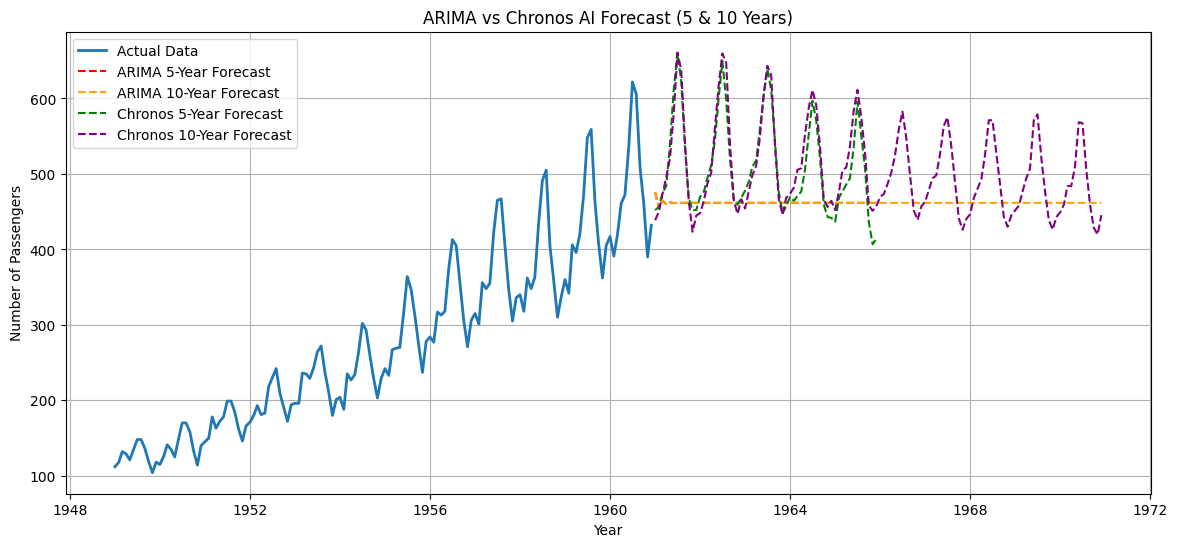

In [20]:
# ARIMA forecasts (reuse from ARIMA code)
arima_forecast_5 = model_fit.forecast(steps=horizon_5_years)
arima_forecast_10 = model_fit.forecast(steps=horizon_10_years)

plt.figure(figsize=(14, 6))

# Original Data
plt.plot(df.index, df["Passengers"], label="Actual Data", linewidth=2)

# ARIMA Forecasts
plt.plot(
    pd.date_range(df.index[-1], periods=horizon_5_years+1, freq='MS')[1:], 
    arima_forecast_5, label="ARIMA 5-Year Forecast", linestyle='--', color='red'
)
plt.plot(
    pd.date_range(df.index[-1], periods=horizon_10_years+1, freq='MS')[1:], 
    arima_forecast_10, label="ARIMA 10-Year Forecast", linestyle='--', color='orange'
)

# Chronos Forecasts
plt.plot(
    pd.date_range(df.index[-1], periods=horizon_5_years+1, freq='MS')[1:], 
    chronos_median_5, label="Chronos 5-Year Forecast", linestyle='--', color='green'
)
plt.plot(
    pd.date_range(df.index[-1], periods=horizon_10_years+1, freq='MS')[1:], 
    chronos_median_10, label="Chronos 10-Year Forecast", linestyle='--', color='purple'
)

plt.title("ARIMA vs Chronos AI Forecast (5 & 10 Years)")
plt.xlabel("Year")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid(True)
plt.show()


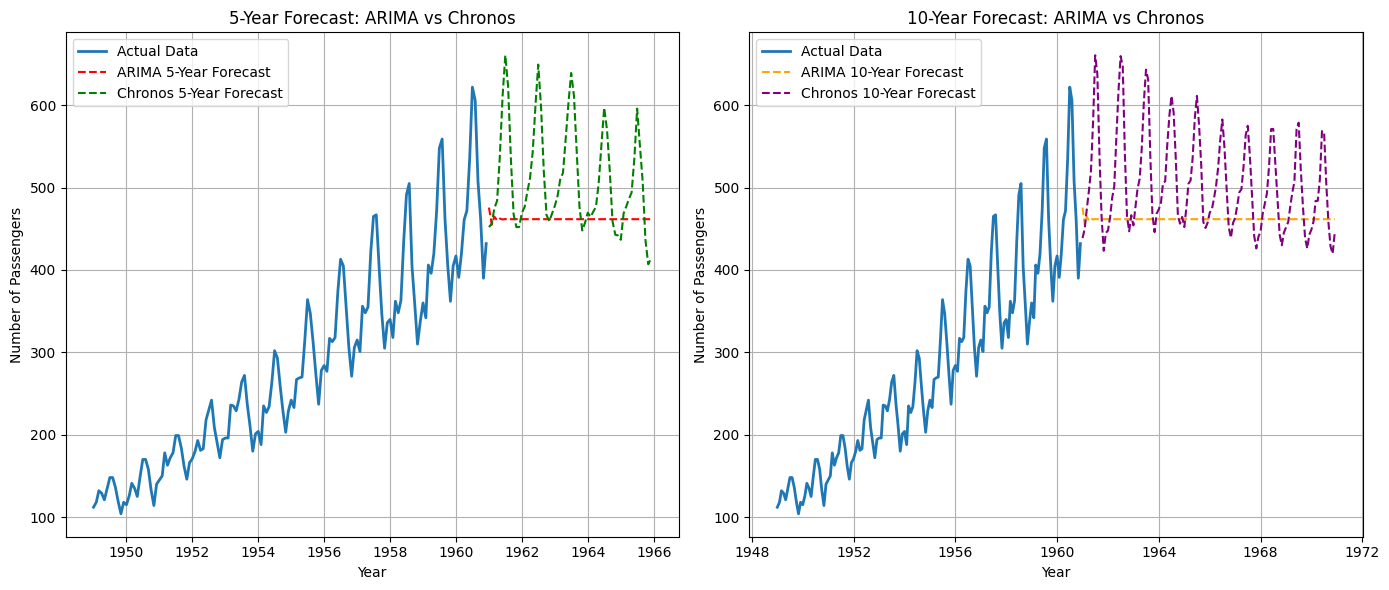

In [21]:
plt.figure(figsize=(14, 6))

# --- Subplot 1: 5-Year Forecast ---
plt.subplot(1, 2, 1)
plt.plot(df.index, df["Passengers"], label="Actual Data", linewidth=2)

# ARIMA 5-Year Forecast
plt.plot(
    pd.date_range(df.index[-1], periods=horizon_5_years+1, freq='MS')[1:], 
    arima_forecast_5, label="ARIMA 5-Year Forecast", linestyle='--', color='red'
)

# Chronos 5-Year Forecast
plt.plot(
    pd.date_range(df.index[-1], periods=horizon_5_years+1, freq='MS')[1:], 
    chronos_median_5, label="Chronos 5-Year Forecast", linestyle='--', color='green'
)

plt.title("5-Year Forecast: ARIMA vs Chronos")
plt.xlabel("Year")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid(True)

# --- Subplot 2: 10-Year Forecast ---
plt.subplot(1, 2, 2)
plt.plot(df.index, df["Passengers"], label="Actual Data", linewidth=2)

# ARIMA 10-Year Forecast
plt.plot(
    pd.date_range(df.index[-1], periods=horizon_10_years+1, freq='MS')[1:], 
    arima_forecast_10, label="ARIMA 10-Year Forecast", linestyle='--', color='orange'
)

# Chronos 10-Year Forecast
plt.plot(
    pd.date_range(df.index[-1], periods=horizon_10_years+1, freq='MS')[1:], 
    chronos_median_10, label="Chronos 10-Year Forecast", linestyle='--', color='purple'
)

plt.title("10-Year Forecast: ARIMA vs Chronos")
plt.xlabel("Year")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid(True)

# --- Show Subplots ---
plt.tight_layout()
plt.show()


##### Conclusion:
- Best Model: Chronos AI is more suitable for this dataset as it preserves trend and seasonality in both short-term and long-term forecasts.
- ARIMA Limitation: ARIMA fails to capture seasonal patterns and produces flat predictions due to its linear nature, especially without proper seasonal adjustments.